## dataset sensitivity

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import sacpy as scp
import xarray as xr
import pandas as pd

In [18]:
best = xr.open_dataset('./data/tas/Berkeley_Earth_Land_and_Ocean_LatLong5.nc').temperature
hadcrut = xr.open_dataset('./data/tas/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc').tas_mean
gistemp = xr.open_dataset('./data/tas/gistemp1200_GHCNv4_ERSSTv5_regrid.nc').tempanomaly
noaa = xr.open_dataset('./data/tas/NOAAGlobalTemp_v5.1.0_gridded_s185001_e202308_c20230908T112802_regrid.nc').anom


In [19]:
best['time'] = pd.date_range(start='1850-01-01', end='2023-09-01', freq='1M')

In [20]:
from functions import preprocess_temp

In [21]:
best_ts = preprocess_temp.calc_gmst(best)
hadcrut_ts = preprocess_temp.calc_gmst(hadcrut)
gistemp_ts = preprocess_temp.calc_gmst(gistemp)
noaa_ts = preprocess_temp.calc_gmst(noaa)

In [22]:
from functions import trend_analysis

In [23]:
best_smooth = pd.DataFrame(data = dict(temp_smooth = preprocess_temp.loess1d(best_ts), year = best_ts['year'].to_numpy())).set_index('year').to_xarray().temp_smooth
hadcrut_smooth = pd.DataFrame(data = dict(temp_smooth = preprocess_temp.loess1d(hadcrut_ts), year = hadcrut_ts['year'].to_numpy())).set_index('year').to_xarray().temp_smooth
gistemp_smooth = pd.DataFrame(data = dict(temp_smooth = preprocess_temp.loess1d(gistemp_ts), year = gistemp_ts['year'].to_numpy())).set_index('year').to_xarray().temp_smooth
noaa_smooth = pd.DataFrame(data = dict(temp_smooth = preprocess_temp.loess1d(noaa_ts.isel(z=0)), year = noaa_ts['year'].to_numpy())).set_index('year').to_xarray().temp_smooth

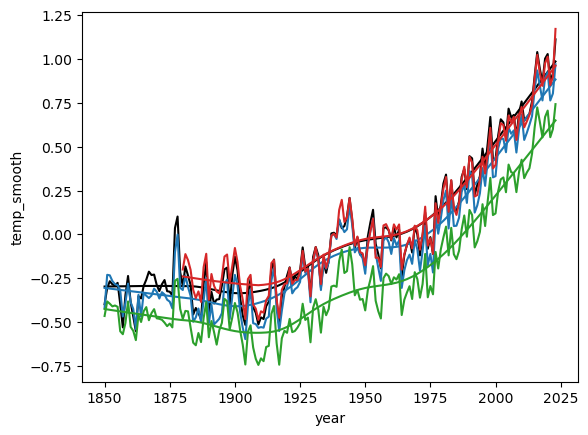

In [24]:
best_ts.plot(color='k')
best_smooth.plot(color='k')

hadcrut_ts.plot(color='tab:blue')
hadcrut_smooth.plot(color='tab:blue')

gistemp_ts.plot(color='tab:red')
gistemp_smooth.plot(color='tab:red')

noaa_ts.plot(color='tab:green')
noaa_smooth.plot(color='tab:green')

In [25]:
sy, ey, slope_best, _, _ = trend_analysis.get_all_trends(best_smooth, initial_dur=30)
_, _, slope_hadcrut, _, _ = trend_analysis.get_all_trends(hadcrut_smooth, initial_dur=30)
_, _, slope_gistemp, _, _ = trend_analysis.get_all_trends(gistemp_smooth, initial_dur=30)
_, _, slope_noaa, _, _ = trend_analysis.get_all_trends(noaa_smooth, initial_dur=30)

In [26]:
import seaborn as sns

<Axes: ylabel='Density'>

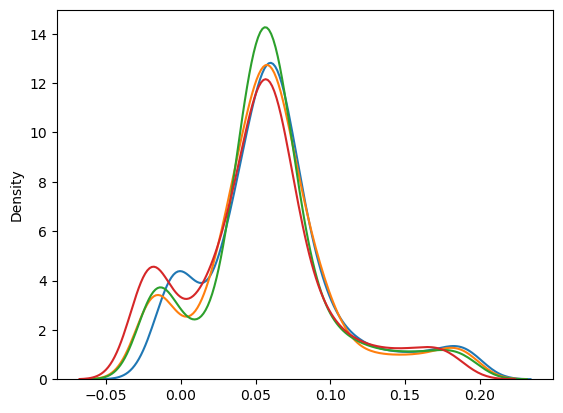

In [27]:
sns.kdeplot(slope_best.flatten())
sns.kdeplot(slope_hadcrut.flatten())
sns.kdeplot(slope_gistemp.flatten())
sns.kdeplot(slope_noaa.flatten())

In [28]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples

In [29]:
x, y = np.meshgrid(sy, ey)

(-0.05, 0.22)

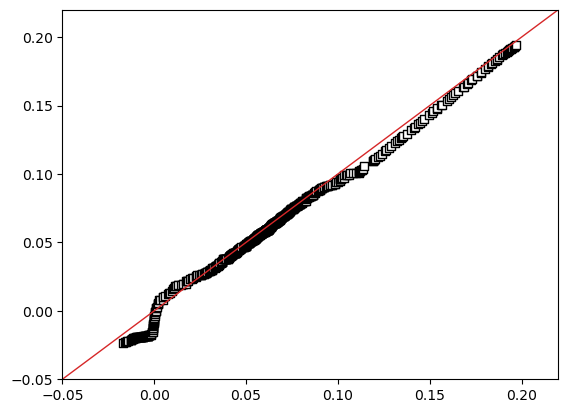

In [30]:
plt.scatter(np.sort(slope_best.flatten()), np.sort(slope_hadcrut.flatten()), marker='s', color='k', facecolor='white')
plt.plot([-1, 1], [-1, 1], color='tab:red', ls='-', lw=1.0)
plt.xlim(-0.05 ,0.22)
plt.ylim(-0.05 ,0.22)

(-0.05, 0.22)

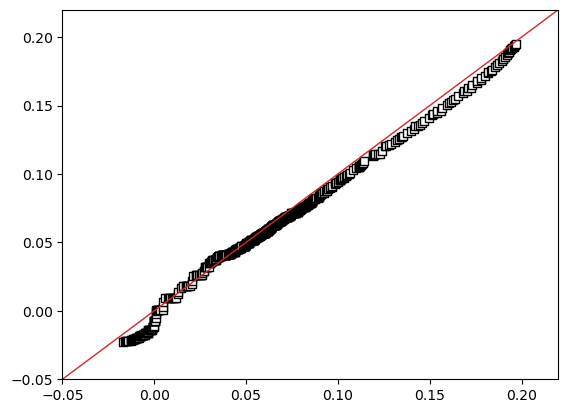

In [31]:
plt.scatter(np.sort(slope_best.flatten()), np.sort(slope_gistemp.flatten()), marker='s', color='k', facecolor='white')
plt.plot([-1, 1], [-1, 1], color='tab:red', ls='-', lw=1.0)
plt.xlim(-0.05 ,0.22)
plt.ylim(-0.05 ,0.22)

In [32]:
best_preproc = preprocess_temp.loess3d(best.ffill('time').bfill('time').groupby('time.year').mean('time'), dim='year')
hadcrut_preproc = preprocess_temp.loess3d(hadcrut.ffill('time').bfill('time').groupby('time.year').mean('time'), dim='year')
noaa_preproc = preprocess_temp.loess3d(noaa.ffill('time').bfill('time').groupby('time.year').mean('time'), dim='year')
gistemp_preproc = preprocess_temp.loess3d(gistemp.ffill('time').bfill('time').groupby('time.year').mean('time'), dim='year')

In [33]:
len(best_preproc['year'])

174

In [34]:
trend_pattern_corr1, trend_pattern_pvals1, bias1, frac_bias1, rmse1 = trend_analysis.calc_sensitivity(best_data=best_preproc, temp_data=noaa_preproc, dim='year', duration=32, gap=4)
trend_pattern_corr2, trend_pattern_pvals2, bias2, frac_bias2, rmse2 = trend_analysis.calc_sensitivity(best_data=best_preproc, temp_data=hadcrut_preproc, dim='year', duration=32, gap=4)
trend_pattern_corr3, trend_pattern_pvals3, bias3, frac_bias3, rmse3 = trend_analysis.calc_sensitivity(best_data=best_preproc.sel(year = slice("1882", "2023")), temp_data=gistemp_preproc.sel(year = slice("1882", "2023")), dim='year', duration=32, gap=4)

1850
1854
1858
1862
1866
1870
1874
1878
1882
1886
1890
1894
1898
1902
1906
1910
1914
1918
1922
1926
1930
1934
1938
1942
1946
1950
1954
1958
1962
1966
1970
1974
1978
1982
1986
1990
1850
1854
1858
1862
1866
1870
1874
1878
1882
1886
1890
1894
1898
1902
1906
1910
1914
1918
1922
1926
1930
1934
1938
1942
1946
1950
1954
1958
1962
1966
1970
1974
1978
1982
1986
1990
1882
1886
1890
1894
1898
1902
1906
1910
1914
1918
1922
1926
1930
1934
1938
1942
1946
1950
1954
1958
1962
1966
1970
1974
1978
1982
1986
1990


In [35]:
trend_pattern_corr3 = np.hstack((np.ones((8))*np.nan, trend_pattern_corr3))
trend_pattern_pvals3 =  np.hstack((np.ones((8)), trend_pattern_pvals3))
bias3 =  np.hstack((np.ones((8))*np.nan, bias3))
frac_bias3 =  np.hstack((np.ones((8))*np.nan, frac_bias3))
rmse3 =  np.hstack((np.ones((8))*np.nan, rmse3))

In [108]:
data_df = pd.DataFrame(dict(year = np.arange(1882, 2026, 4), NOAAGlobalTemp = trend_pattern_corr1, HadCRUT5 = trend_pattern_corr2, GISTEMP = trend_pattern_corr3))
pval_df = pd.DataFrame(dict(year = np.arange(1882, 2026, 4), NOAAGlobalTemp = trend_pattern_pvals1, HadCRUT5 = trend_pattern_pvals2, GISTEMP = trend_pattern_pvals3))
data_df = data_df.set_index('year')
pval_df = pval_df.set_index('year')

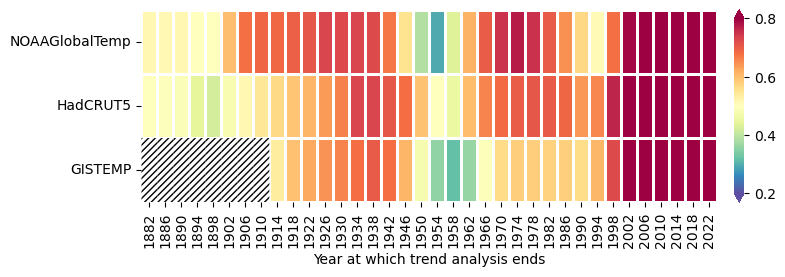

In [109]:
plt.figure(figsize=(9,2.5))
sns.heatmap(data_df.transpose(), cmap='Spectral_r', vmin=0.2, vmax=0.8, cbar_kws=dict(extend='both', pad=0.025), linewidths=1.0, linecolor='white')
zm = np.ma.masked_less(pval_df.transpose().values, 0.05)
x, y = np.arange(len(pval_df.transpose().columns) + 1), np.arange(len(pval_df.transpose().index) + 1)
plt.pcolor(x, y, zm, hatch = '/////', alpha=0.)
plt.xlabel('Year at which trend analysis ends')
plt.savefig('./images/sensitivity_corrs.png', dpi=300, bbox_inches='tight')

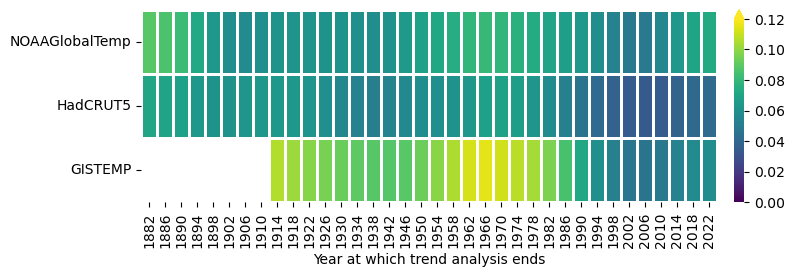

In [106]:
plt.figure(figsize=(9,2.5))
sns.heatmap(data_df.transpose(), cmap='viridis', vmin=0, vmax=0.12, cbar_kws=dict(extend='max', pad=0.025), linewidths=1.0, linecolor='white')
plt.xlabel('Year at which trend analysis ends')
plt.savefig('./images/sensitivity_bias.png', dpi=300, bbox_inches='tight')

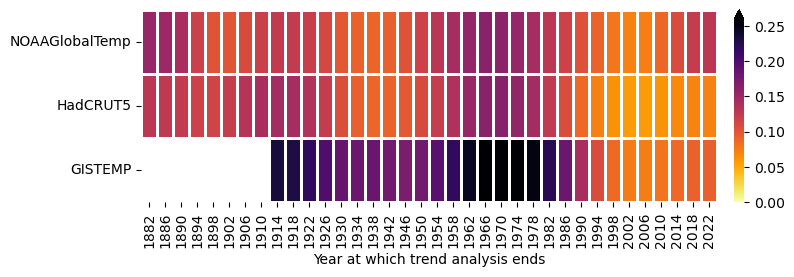

In [104]:
plt.figure(figsize=(9,2.5))
sns.heatmap(data_df.transpose(), cmap='inferno_r', vmin=0, vmax=0.26, cbar_kws=dict(extend='max', pad=0.025), linewidths=1.0, linecolor='white')
plt.xlabel('Year at which trend analysis ends')
plt.savefig('./images/sensitivity_rmse.png', dpi=300, bbox_inches='tight')